# Threaded implementation below

As suggested in issue 26

In [1]:
# Draft from github post
from concurrent.futures import ThreadPoolExecutor

import numpy as np
from random import Random
from typing import List, Tuple
from abc import ABC, abstractmethod
import time
import sys
import matplotlib.pyplot as plt
import random
import open3d as o3d
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

class BaseRansac(ABC):
    def __init__(self, seed=None, n_workers=None):
        self.random = Random(seed)
        self.n_workers = n_workers
        self.executor = ThreadPoolExecutor(max_workers=n_workers)

    def fit(self, points: np.ndarray, thresh: float = 0.05, max_iteration: int = 5000) -> Tuple[List[float], List[float]]:
        """
        :param points: A numpy array of points, of shape (# points, 3)
        :param thresh: The distance threshold to include points as inliers
        :param max_iteration: How many (parallel) Ransac iterations to run
        :returns:
            best_eq: A list of integers representing the best 'equation' for the primitive shape.
            best_inliers: A list of indices of points that fit the shape.
        """
        best_eq = []
        best_inliers = []

        jobs = ((points, float(thresh)) for _ in range(max_iteration))
        # We can use a with statement to ensure threads are cleaned up promptly
        for eq, point_id_inliers in self.executor.map(self.iteration, *zip(*jobs)):
            if len(point_id_inliers) > len(best_inliers):
                best_eq = eq
                best_inliers = point_id_inliers
        return best_eq, best_inliers

    @abstractmethod
    def iteration(self, points: np.ndarray, thresh: float) -> Tuple[List[float], List[float]]:
        pass

class PlaneClass(BaseRansac):
    def iteration(self, pts: np.ndarray, thresh: float)-> Tuple[List[float], List[float]]:
        # Samples 3 random points
        id_samples = self.random.sample(range(0, pts.shape[0]), 3)
        pt_samples = pts[id_samples]

        # We have to find the plane equation described by those 3 points
        # We find first 2 vectors that are part of this plane
        # A = pt2 - pt1
        # B = pt3 - pt1

        vecA = pt_samples[1, :] - pt_samples[0, :]
        vecB = pt_samples[2, :] - pt_samples[0, :]

        # Now we compute the cross product of vecA and vecB to get vecC which is normal to the plane
        vecC = np.cross(vecA, vecB)

        # The plane equation will be vecC[0]*x + vecC[1]*y + vecC[0]*z = -k
        # We have to use a point to find k
        vecC = vecC / np.linalg.norm(vecC)
        k = -np.sum(np.multiply(vecC, pt_samples[1, :]))
        plane_eq = [vecC[0], vecC[1], vecC[2], k]

        # Distance from a point to a plane
        # https://mathworld.wolfram.com/Point-PlaneDistance.html
        pt_id_inliers = []  # list of inliers ids
        dist_pt = (
            plane_eq[0] * pts[:, 0] + plane_eq[1] * pts[:, 1] + plane_eq[2] * pts[:, 2] + plane_eq[3]
        ) / np.sqrt(plane_eq[0] ** 2 + plane_eq[1] ** 2 + plane_eq[2] ** 2)

        # Select indexes where distance is biggers than the threshold
        pt_id_inliers = np.where(np.abs(dist_pt) <= thresh)[0]
        return list(pts), list(pt_id_inliers)

# Default implementation below

In [2]:
class Plane:
    """
    Implementation of planar RANSAC.

    Class for Plane object, which finds the equation of a infinite plane using RANSAC algorithim.

    Call `fit(.)` to randomly take 3 points of pointcloud to verify inliers based on a threshold.

    ![Plane](https://raw.githubusercontent.com/leomariga/pyRANSAC-3D/master/doc/plano.gif "Plane")

    ---
    """

    def __init__(self):
        self.inliers = []
        self.equation = []

    def fit(self, pts, thresh=0.05, minPoints=100, maxIteration=1000):
        """
        Find the best equation for a plane.

        :param pts: 3D point cloud as a `np.array (N,3)`.
        :param thresh: Threshold distance from the plane which is considered inlier.
        :param maxIteration: Number of maximum iteration which RANSAC will loop over.
        :returns:
        - `self.equation`:  Parameters of the plane using Ax+By+Cy+D `np.array (1, 4)`
        - `self.inliers`: points from the dataset considered inliers

        ---
        """
        n_points = pts.shape[0]
        best_eq = []
        best_inliers = []

        for it in range(maxIteration):

            # Samples 3 random points
            id_samples = random.sample(range(0, n_points), 3)
            pt_samples = pts[id_samples]

            # We have to find the plane equation described by those 3 points
            # We find first 2 vectors that are part of this plane
            # A = pt2 - pt1
            # B = pt3 - pt1

            vecA = pt_samples[1, :] - pt_samples[0, :]
            vecB = pt_samples[2, :] - pt_samples[0, :]

            # Now we compute the cross product of vecA and vecB to get vecC which is normal to the plane
            vecC = np.cross(vecA, vecB)

            # The plane equation will be vecC[0]*x + vecC[1]*y + vecC[0]*z = -k
            # We have to use a point to find k
            vecC = vecC / np.linalg.norm(vecC)
            k = -np.sum(np.multiply(vecC, pt_samples[1, :]))
            plane_eq = [vecC[0], vecC[1], vecC[2], k]

            # Distance from a point to a plane
            # https://mathworld.wolfram.com/Point-PlaneDistance.html
            pt_id_inliers = []  # list of inliers ids
            dist_pt = (
                plane_eq[0] * pts[:, 0] + plane_eq[1] * pts[:, 1] + plane_eq[2] * pts[:, 2] + plane_eq[3]
            ) / np.sqrt(plane_eq[0] ** 2 + plane_eq[1] ** 2 + plane_eq[2] ** 2)

            # Select indexes where distance is biggers than the threshold
            pt_id_inliers = np.where(np.abs(dist_pt) <= thresh)[0]
            if len(pt_id_inliers) > len(best_inliers):
                best_eq = plane_eq
                best_inliers = pt_id_inliers
            self.inliers = best_inliers
            self.equation = best_eq

        return self.equation, self.inliers


# Set number of workers and max iteration for analysis

In [3]:
# nworkersList = [1, 2, 5, 10, 50, 100]#, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300 ,400, 500, 600, 700, 800, 900, 1000]

# maxIterationList = [50, 200, 1000]#, 500, 1000, 2000, 5000]

nworkersList = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 100, 200, 300, 400, 500]

maxIterationList = [50, 100, 500, 1000, 2000]

# Execute and plot the time analysis

50  -  1  -  0.435957670211792
50  -  2  -  0.37571263313293457
50  -  3  -  0.42105841636657715
50  -  4  -  0.44687962532043457
50  -  5  -  0.47943997383117676
50  -  6  -  0.415083646774292
50  -  7  -  0.40845417976379395
50  -  8  -  0.41558194160461426
50  -  9  -  0.41582536697387695
50  -  10  -  0.4170217514038086
50  -  20  -  0.4372868537902832
50  -  30  -  0.45375847816467285
50  -  40  -  0.458629846572876
50  -  50  -  0.48370361328125
50  -  60  -  0.47148680686950684
50  -  70  -  0.5590903759002686
50  -  80  -  0.6678285598754883
50  -  100  -  0.5460212230682373
50  -  200  -  0.7117092609405518
50  -  300  -  0.554448127746582
50  -  400  -  0.46762537956237793
50  -  500  -  0.5543370246887207
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 100, 200, 300, 400, 500]
[0.435957670211792, 0.37571263313293457, 0.42105841636657715, 0.44687962532043457, 0.47943997383117676, 0.415083646774292, 0.40845417976379395, 0.41558194160461426, 0.41582536697387695, 0.4

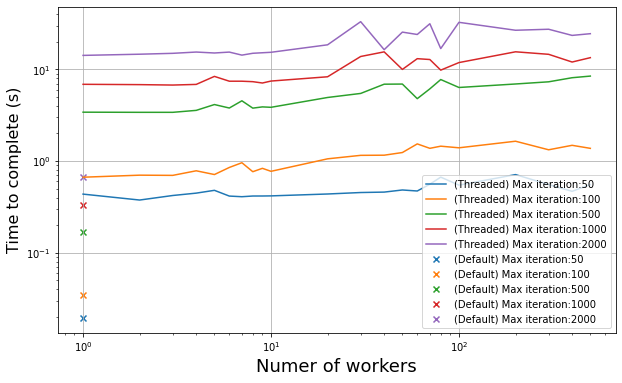

<Figure size 3000x1800 with 0 Axes>

In [4]:
# Load saved point cloud and visualize it
pcd_load = o3d.io.read_point_cloud("dataset/caixa.ply")
# o3d.visualization.draw_geometries([pcd_load])
points = np.asarray(pcd_load.points)

t_results = {}
for max_iteration in maxIterationList:
    t_results[max_iteration] = []
    r = []
    x = []
    y = []
    for n_workers in nworkersList:

        t_before = time.time()
        plano1 = PlaneClass(n_workers = n_workers)
        best_eq, best_inliers = plano1.fit(points, 0.01, max_iteration=max_iteration)
        dt = time.time() - t_before
        x.append(n_workers)
        y.append(dt)
        r.append(dt)
        print(max_iteration, " - ",n_workers, " - ", dt)
    t_results[max_iteration].append(r)
    print(x)
    print(y)
    plt.plot(x, y, label = "(Threaded) Max iteration:"+str(max_iteration))

    # Default class
    t_before = time.time()
    plano2 = Plane()
    best_eq, best_inliers = plano2.fit(points, 0.01, maxIteration=max_iteration)
    dt = time.time() - t_before
    plt.scatter(1, dt, label = "(Default) Max iteration:"+str(max_iteration), marker="x" )
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend(loc="lower right")
plt.xlabel('Numer of workers', fontsize=18)
plt.ylabel('Time to complete (s)', fontsize=16)
figure(figsize=(10, 6), dpi=300)
plt.show()